Importing Dependencies and stuff


Importing os and stuff 

In [1]:
import os
import pandas as pd
import numpy as np
import json
import warnings

Importing SKlearn Stuff 

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report


In [3]:
# xgboost Model
from xgboost import XGBClassifier

Importing Matplot 

In [4]:
import matplotlib.pyplot as plt

Importing sea born

In [5]:
import seaborn as sns

Importing data set 

In [6]:
data = pd.read_csv('heart.csv')
data.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


Random stuff (basic stats)

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64
              age         sex          cp      trtbps        chol         fbs  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean    54.366337    0.683168    0.966997  131.623762  246.264026    0.148515   
std      9.082101    0.466011    1.032052   17.538143   51.830751    0.356198   
min     29.000000    0.000000    0.000000   94.000000  126.000000    0.000000   
25%     47.500000    0.000000    0.000000  120.000000  211.000000    0.000000   
50%     55.000000    1.000000    1.000000  130.000000  240.000000    0.000000   
75%     61.000000    1.000000    2.000000  140.000000  274.500000    0.000000   
max     77.000000    1.000000    3.000000  200.000000  564.000000    1.000000   

          restecg    thalachh        exng     oldpeak        

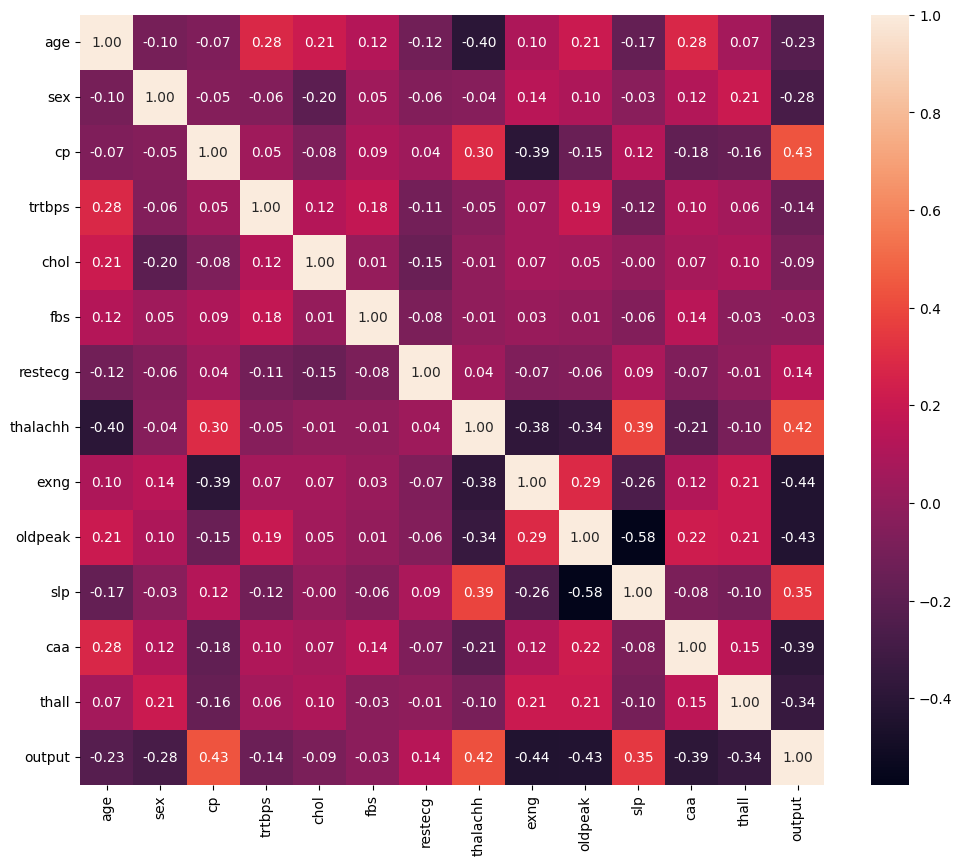

In [7]:

print(data.isnull().sum())
print(data.describe())
plt.figure(figsize=(12,10))
sns.heatmap(data.corr(), annot=True, fmt='.2f')
plt.show()

Separate features and target

In [8]:
X = data.drop('output', axis=1)
y = data['output']

Standardize the features

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Split the data into training and testing sets
Note: might need to change test size and random state to give better appoxmiations 

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

Define the models

In [11]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "SVM": SVC(probability=True),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "Naive Bayes": GaussianNB(),
    "LDA": LinearDiscriminantAnalysis()
}

Creating folder and storing results 

In [12]:
base_dir = "results"
os.makedirs(base_dir, exist_ok=True)

results = []

Train and evaluate models

In [13]:

# Suppress warnings from XGBoost
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")

num_tests = 5

for model_name, model in models.items():
    print(f"Training {model_name}...")
    model_dir = os.path.join(base_dir, model_name.replace(" ", "_"))
    os.makedirs(model_dir, exist_ok=True)
    
    accuracies = []
    roc_aucs = []
    for i in range(num_tests):
        # Special handling for AdaBoost to avoid SAMME.R warning
        if model_name == "AdaBoost":
            model.set_params(algorithm='SAMME')

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
        
        # Calculate accuracy and ROC AUC
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
        accuracies.append(accuracy)
        roc_aucs.append(roc_auc)
        
        # Generate confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.title(f"{model_name} Confusion Matrix (Test {i+1})")
        plt.savefig(os.path.join(model_dir, f"confusion_matrix_{i+1}.png"))
        plt.close()
        
        # Save predictions
        np.save(os.path.join(model_dir, f"y_pred_{i+1}.npy"), y_pred)
        if y_prob is not None:
            np.save(os.path.join(model_dir, f"y_prob_{i+1}.npy"), y_prob)
    
    # Calculate average accuracy and ROC AUC
    avg_accuracy = np.mean(accuracies)
    avg_roc_auc = np.mean([auc for auc in roc_aucs if auc is not None])  # Filter out None values
    
    # Store results
    results.append({
        "Model": model_name,
        "Accuracy": avg_accuracy,
        "ROC AUC": avg_roc_auc
    })
    
    # Save accuracy and ROC AUC plots
    plt.figure()
    plt.plot(range(1, num_tests + 1), accuracies, label="Accuracy")
    plt.plot(range(1, num_tests + 1), roc_aucs, label="ROC AUC")
    plt.xlabel("Test Number")
    plt.ylabel("Score")
    plt.title(f"{model_name} Accuracy and ROC AUC over {num_tests} Tests")
    plt.legend()
    plt.savefig(os.path.join(model_dir, "accuracy_roc_auc.png"))
    plt.close()
    
    # Save training logs and data
    with open(os.path.join(model_dir, "training_log.txt"), "w") as log_file:
        log_file.write(f"Training {model_name}...\n")
        log_file.write(f"Average Accuracy: {avg_accuracy}\n")
        log_file.write(f"Average ROC AUC: {avg_roc_auc}\n")
    
    # Save classification report for the last test
    report = classification_report(y_test, y_pred, output_dict=True)
    with open(os.path.join(model_dir, "classification_report.json"), "w") as f:
        json.dump(report, f, indent=4)

Training Logistic Regression...
Training Random Forest...
Training Gradient Boosting...
Training AdaBoost...
Training SVM...
Training K-Nearest Neighbors...
Training Decision Tree...
Training XGBoost...
Training Naive Bayes...
Training LDA...


Save the overall results to a CSV file

In [14]:

results_df = pd.DataFrame(results)
results_df.to_csv(os.path.join(base_dir, "model_comparison.csv"), index=False)

plotting model accuracy comparison

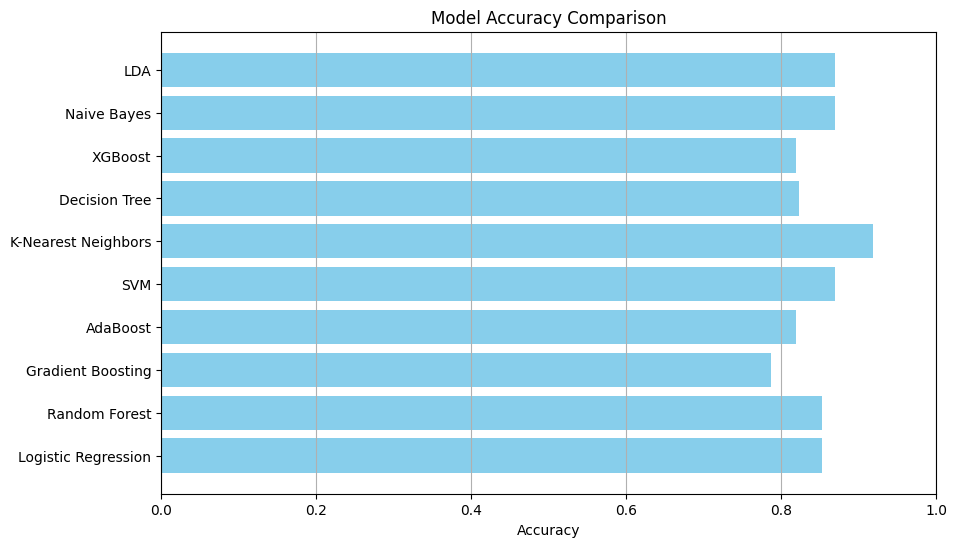

In [15]:
plt.figure(figsize=(10, 6))
plt.barh(results_df['Model'], results_df['Accuracy'], color='skyblue')
plt.xlabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xlim(0, 1)
plt.grid(axis='x')
plt.show()


Plotting model ROC AUC comparison

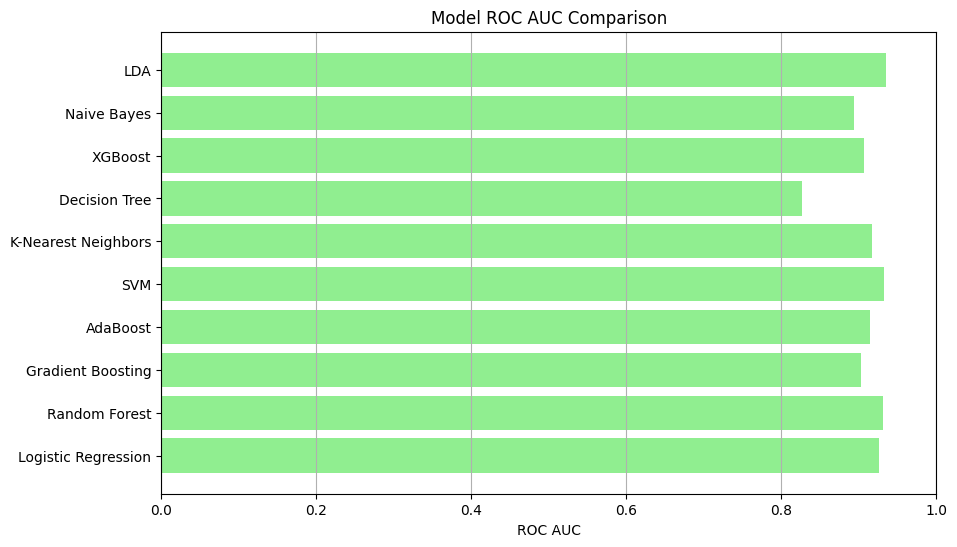

In [16]:
plt.figure(figsize=(10, 6))
plt.barh(results_df['Model'], results_df['ROC AUC'], color='lightgreen')
plt.xlabel('ROC AUC')
plt.title('Model ROC AUC Comparison')
plt.xlim(0, 1)
plt.grid(axis='x')
plt.show()

Find best model 

In [17]:
best_model = max(results, key=lambda x: x["Accuracy"])
print("Best Model:", best_model["Model"])
print("Accuracy:", best_model["Accuracy"])
print("ROC AUC:", best_model["ROC AUC"])

Best Model: K-Nearest Neighbors
Accuracy: 0.9180327868852458
ROC AUC: 0.9175646551724139
